In [1]:
from strava.data.cache import Cache
from strava.data.strava_requests import *
from strava.plotting.strava_annual_plots import *
from strava.plotting.strava_stream_plots import *
from generate_plots import get_clean_activities

import aiohttp
import asyncio
import copy
from datetime import date
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import os
import pandas as pd
from pandas_profiling import ProfileReport
from plotnine import ggplot, aes
import plotnine as gg
import time
from typing import List
import urllib3
import PIL
from PIL import Image
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
gg.options.figure_size = (11, 8.5)
pt.dark()

pd.set_option('display.max_columns', 500)

## Get the Raw data and create a copy

In [2]:
activities_data_raw = retrieve_activities()

Existing access token is valid.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 200 activities.
-> Received page 4 with 36 activities.
-> Received page 5 with 0 activities.
...retrieved total of 636 activities.


In [3]:
# This can be re-run to refresh "data" in case of modification in case I don't want to request the raw_data again
activities_data = copy.deepcopy(activities_data_raw)
activities_df = pd.json_normalize(activities_data)

In [4]:
activities = get_clean_activities()
activities.head()

Existing access token is valid.
Beginning request of activities...
-> Received page 1 with 200 activities.
-> Received page 2 with 200 activities.
-> Received page 3 with 200 activities.
-> Received page 4 with 36 activities.
-> Received page 5 with 0 activities.
...retrieved total of 636 activities.


,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
0,14218149073,Afternoon Ride,28507.2,0 days 01:17:43,0 days 01:19:52,352.0,100.6,3.4,Ride,2025-04-18 16:41:11,(GMT-08:00) America/Vancouver,"[49.055033, -122.7746]","[49.055058, -122.77465]",4,a14218149073,NaN,22.0068,59.184,167.7,189.0,e_ljHpsjlVPUDFDbA`@x@JtAn@hCPhBh@x@F`BPh@LHjCG...,2025,1970-04-18 16:41:11
1,14208696270,Afternoon Ride,28463.9,0 days 01:11:30,0 days 01:13:01,352.2,100.6,3.4,Ride,2025-04-17 16:51:20,(GMT-08:00) America/Vancouver,"[49.055069, -122.774553]","[49.055062, -122.774649]",1,a14208696270,NaN,23.8860,59.688,169.6,185.0,w`ljHltjlVH?VWRAPWHDCb@Dh@^x@N`Br@rCFfA\b@JVFz...,2025,1970-04-17 16:51:20
3,14180028159,Afternoon Ride,28424.2,0 days 01:13:00,0 days 01:16:48,352.8,100.6,3.4,Ride,2025-04-14 16:42:22,(GMT-08:00) America/Vancouver,"[49.055064, -122.774556]","[49.055044, -122.774662]",0,a14180028159,NaN,23.3640,58.320,169.9,187.0,kaljHhujlVL`@Z`@ZI^o@HDT`@Bn@Lv@n@fCJzA\^HVD\@...,2025,1970-04-14 16:42:22
4,14169893236,Afternoon Ride,28489.4,0 days 01:14:38,0 days 01:17:33,353.1,100.6,3.4,Ride,2025-04-13 13:20:56,(GMT-08:00) America/Vancouver,"[49.055083, -122.774517]","[49.05505, -122.774656]",4,a14169893236,NaN,22.9032,58.320,171.1,193.0,qaljH|tjlVf@lAZEd@m@JDRd@D`At@vCPfB^d@HTDZ@p@R...,2025,1970-04-13 13:20:56
5,14150724069,Afternoon Ride,28428.8,0 days 01:14:10,0 days 01:18:07,352.3,100.6,3.4,Ride,2025-04-11 17:06:43,(GMT-08:00) America/Vancouver,"[49.055099, -122.774567]","[49.055068, -122.7746]",0,a14150724069,NaN,22.9968,58.464,168.5,185.0,o`ljHdtjlVXYP?RS?`A`@x@TjBn@lCHlAh@`AF\?t@Nr@X...,2025,1970-04-11 17:06:43


In [5]:
activities.query('year == 2024')

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
55,11214280814,Collision special,20172.3,0 days 00:52:49,34 days 03:57:33,235.7,101.1,3.5,Ride,2024-03-15 16:32:46,(GMT-08:00) America/Vancouver,"[49.05513323843479, -122.77457839809358]","[49.05696954578161, -122.85631871782243]",0,a11214280814,10.0,22.9176,57.0528,176.5,193.0,caljH|tjlVXfANR\Ed@g@D@P^ZpBLj@^dAL`Bb@bA@l@JP...,2024,1970-03-15 16:32:46
67,10818058984,Pre-Season Testing,11187.5,0 days 00:29:14,0 days 00:30:53,109.6,103.1,52.1,Ride,2024-02-22 16:44:42,(GMT-08:00) America/Vancouver,"[49.055141704156995, -122.7743905596435]","[49.055102141574025, -122.77465936727822]",2,a10818058984,10.0,22.9608,41.3640,170.0,188.0,{aljHjtjlV\nANXJHFBHEJ_@`@a@D?PV?`ADh@THVzAF`@...,2024,1970-02-22 16:44:42


## Cleaning Data and converting to more useful formats/units

In [6]:
columns_of_interest = ["id", "name", "distance", "moving_time", "elapsed_time", "total_elevation_gain", "elev_high", "elev_low", 
                        "sport_type", "start_date_local", "timezone", "start_latlng", "end_latlng", "achievement_count", "map.id", 
                        "workout_type", "average_speed", "max_speed", "average_heartrate", "max_heartrate", "map.summary_polyline"]
activities_df = activities_df[columns_of_interest]
activities_df.head(1)

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline
0,14218149073,Afternoon Ride,28507.2,4663,4792,352.0,100.6,3.4,Ride,2025-04-18T16:41:11Z,(GMT-08:00) America/Vancouver,"[49.055033, -122.7746]","[49.055058, -122.77465]",4,a14218149073,NaN,6.113,16.44,167.7,189.0,e_ljHpsjlVPUDFDbA`@x@JtAn@hCPhBh@x@F`BPh@LHjCG...


In [7]:
# Convert dates and times to datetime
activities_df["start_date_local"] = pd.to_datetime(activities_df["start_date_local"], format="%Y-%m-%dT%H:%M:%SZ")
for s in ["moving_time", "elapsed_time"]:
    activities_df[s] = pd.to_timedelta(activities_df[s], unit='S')
# Create a column holding only the year and a column 
activities_df["year"] = activities_df["start_date_local"].apply(lambda x: x.year)
activities_df["date_year_agnostic"] = activities_df["start_date_local"].apply(lambda x: x.replace(year=2020))

# Units
activities_df[["average_speed", "max_speed"]] = activities_df[["average_speed", "max_speed"]] * 3.6

# Filter
activities_df = activities_df.loc[activities_df.sport_type == "Ride"]     # Select only bicycling activities
activities_df = activities_df.loc[activities_df.max_speed > 0.1]          # Remove any throwaway activities
activities_df = activities_df.loc[activities_df.average_heartrate > 145]  # Remove any activities where I wasn't trying that hard
activities_df.head(2)

,id,name,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,sport_type,start_date_local,timezone,start_latlng,end_latlng,achievement_count,map.id,workout_type,average_speed,max_speed,average_heartrate,max_heartrate,map.summary_polyline,year,date_year_agnostic
0,14218149073,Afternoon Ride,28507.2,0 days 01:17:43,0 days 01:19:52,352.0,100.6,3.4,Ride,2025-04-18 16:41:11,(GMT-08:00) America/Vancouver,"[49.055033, -122.7746]","[49.055058, -122.77465]",4,a14218149073,NaN,22.0068,59.184,167.7,189.0,e_ljHpsjlVPUDFDbA`@x@JtAn@hCPhBh@x@F`BPh@LHjCG...,2025,2020-04-18 16:41:11
1,14208696270,Afternoon Ride,28463.9,0 days 01:11:30,0 days 01:13:01,352.2,100.6,3.4,Ride,2025-04-17 16:51:20,(GMT-08:00) America/Vancouver,"[49.055069, -122.774553]","[49.055062, -122.774649]",1,a14208696270,NaN,23.8860,59.688,169.6,185.0,w`ljHltjlVH?VWRAPWHDCb@Dh@^x@N`Br@rCFfA\b@JVFz...,2025,2020-04-17 16:51:20


In [8]:
df_test = activities_df.sort_values('start_date_local')[['start_date_local', 'distance', 'total_elevation_gain', 'year']].set_index('start_date_local').groupby('year').cumsum().reset_index()
df_test['year'] = pd.Categorical(df_test.start_date_local.apply(lambda x: x.year))
df_test['doy'] = df_test.start_date_local.apply(lambda x: x.timetuple().tm_yday)
df_melt = df_test.melt(id_vars=['start_date_local', 'year', 'doy'])
df_melt.tail(30)

,start_date_local,year,doy,variable,value
848,2023-08-31 17:41:18,2023,243,total_elevation_gain,23585.6
849,2023-09-01 17:33:03,2023,244,total_elevation_gain,23936.8
850,2023-09-03 10:54:08,2023,246,total_elevation_gain,24593.2
851,2023-09-07 17:38:36,2023,250,total_elevation_gain,24944.4
852,2023-09-10 12:44:27,2023,253,total_elevation_gain,25296.0
853,2023-09-11 17:34:32,2023,254,total_elevation_gain,25646.0
854,2023-09-14 17:31:23,2023,257,total_elevation_gain,25998.5
855,2023-09-20 17:49:55,2023,263,total_elevation_gain,26286.3
856,2023-09-22 17:31:56,2023,265,total_elevation_gain,26636.8
857,2023-09-23 09:35:35,2023,266,total_elevation_gain,26988.3


In [9]:
df_melt.groupby('year')['doy'].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2020,198.0,187.939394,47.764613,107.0,147.50,189.0,222.75,272.0
2021,190.0,181.136842,50.111750,91.0,143.50,180.0,225.50,265.0
2022,276.0,191.681159,58.787257,81.0,141.00,196.5,241.00,303.0
2023,194.0,187.680412,55.894524,95.0,140.00,187.0,234.00,288.0
2024,4.0,64.000000,12.701706,53.0,53.00,64.0,75.00,75.0
2025,16.0,101.125000,5.352569,93.0,97.75,102.0,104.75,108.0


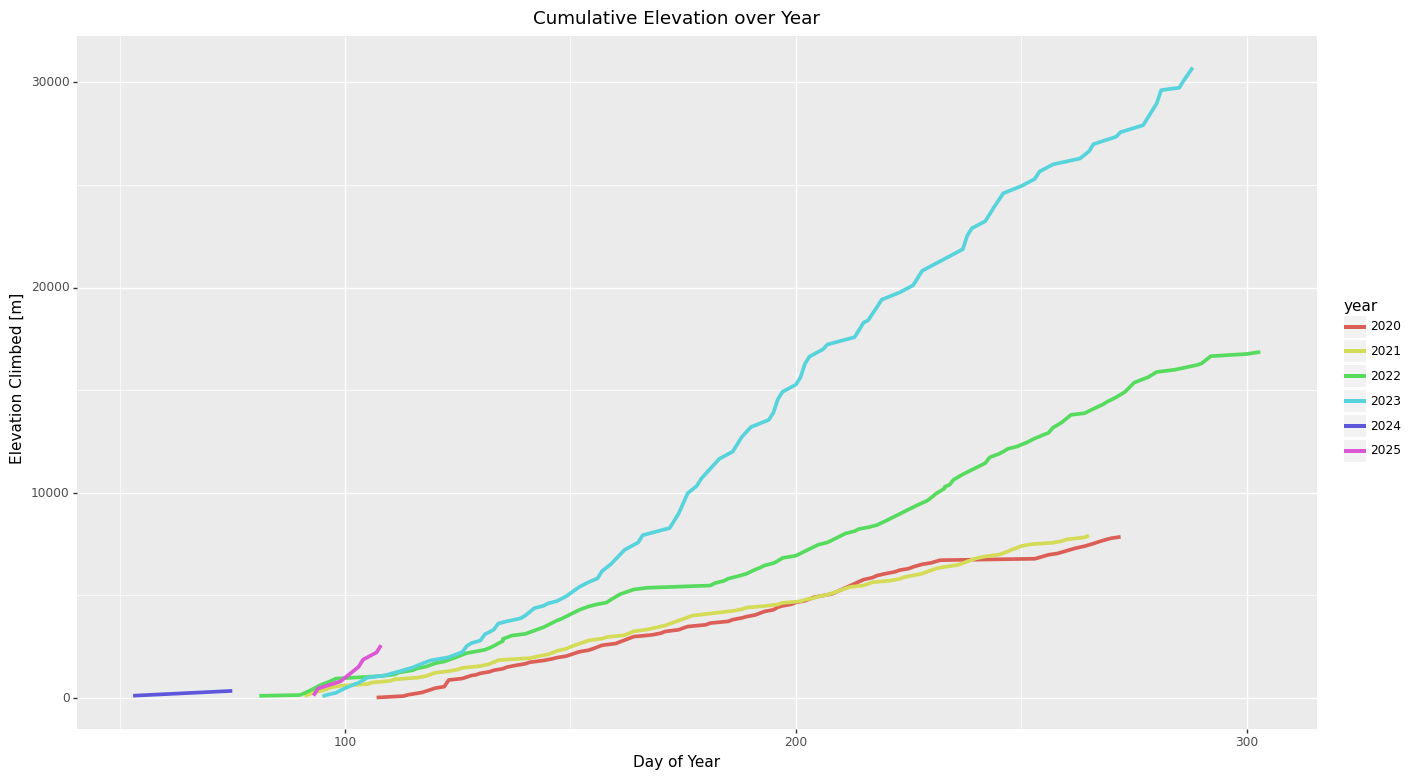

<ggplot: (812817060)>

In [10]:
(gg.ggplot(df_melt.query('variable == "total_elevation_gain"'), gg.aes(x='doy', y='value', colour='year')) 
    + gg.geom_line(size=1.5)
    + gg.theme(figure_size=(16, 9))
    + gg.labs(title='Cumulative Elevation over Year', x='Day of Year', y='Elevation Climbed [m]')
    )

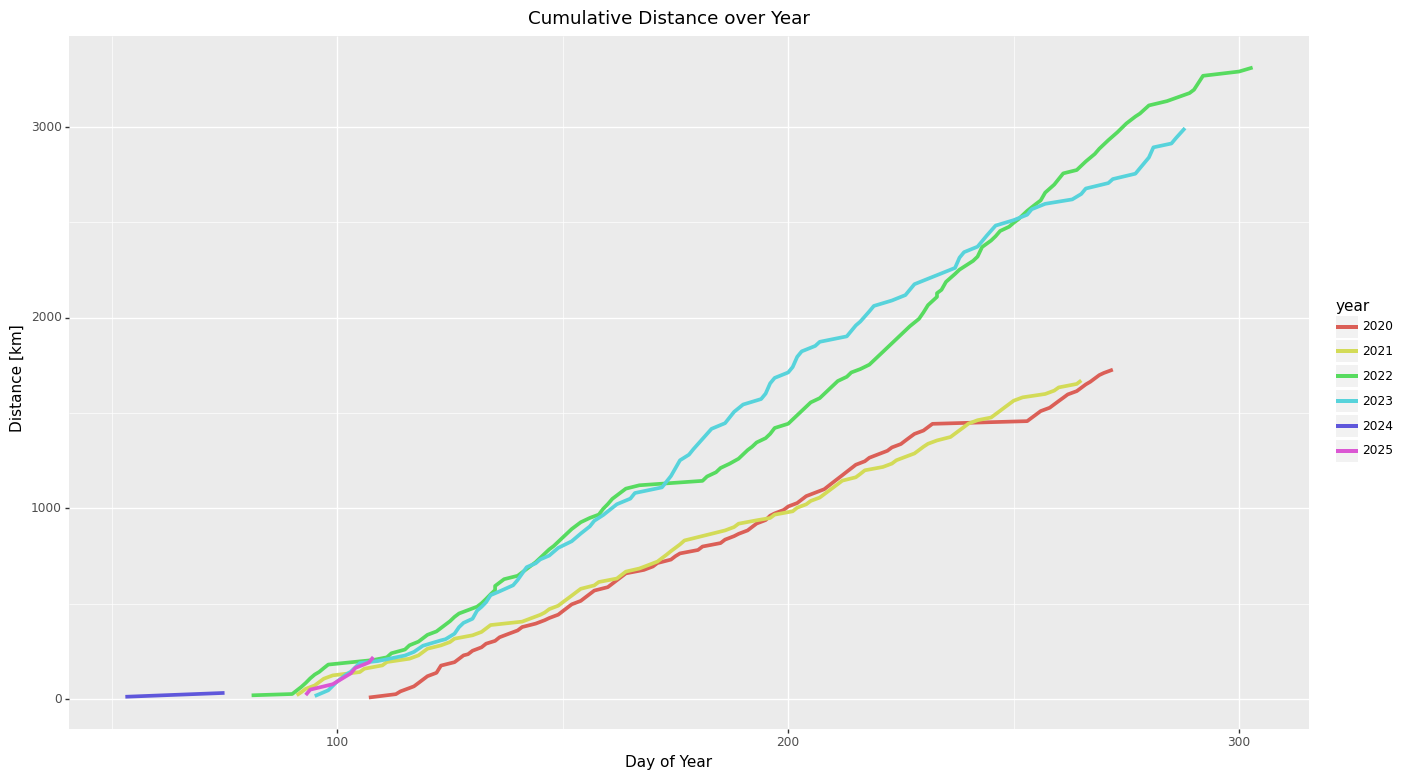

<ggplot: (812903385)>

In [11]:
(gg.ggplot(df_melt.query('variable == "distance"'), gg.aes(x='doy', y='value/1000', colour='year')) 
    + gg.geom_line(size=1.5)
    + gg.theme(figure_size=(16, 9))
    + gg.labs(title='Cumulative Distance over Year', x='Day of Year', y='Distance [km]')
    )

In [12]:
activities_df['e_v_d'] = activities_df.apply(lambda x: x.total_elevation_gain/x.distance * 100, axis=1)
activities_df['doy'] = activities_df.start_date_local.apply(lambda x: x.timetuple().tm_yday)

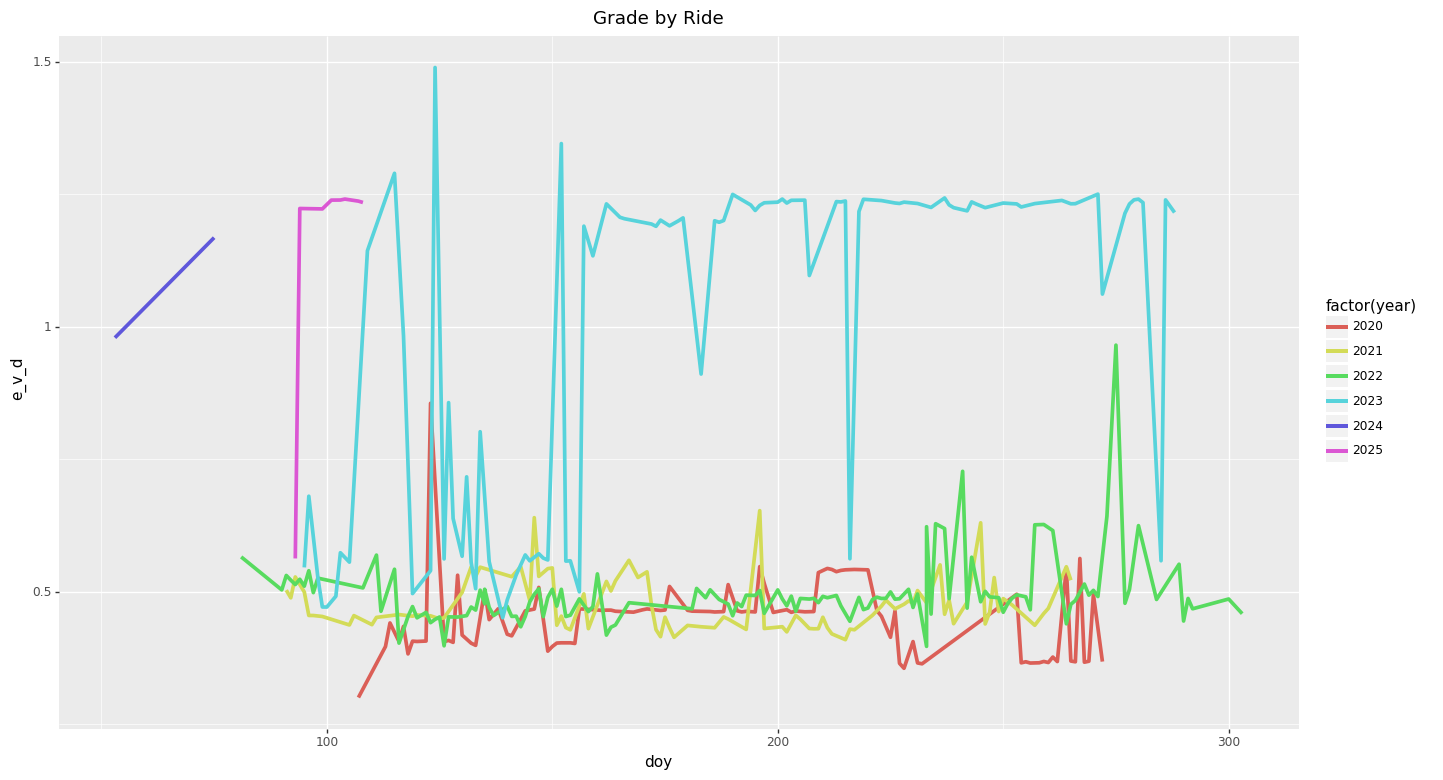

<ggplot: (813097951)>

In [13]:
(gg.ggplot(activities_df, gg.aes(x='doy', y='e_v_d', colour='factor(year)')) 
    + gg.geom_line(size=1.5)
    + gg.theme(figure_size=(16, 9))
    + gg.labs(title='Grade by Ride')
    )

## Getting a stream

In [74]:
cache = Cache()
ride_date = date(2025, 4, 17)
stream = create_stream_df(get_activity_stream_by_date(activities=activities_df, date=ride_date, cache=cache), activity_id_by_date(activities=activities_df, date=ride_date))
stream.rename({"velocity_smooth": "velocity"}, axis=1, inplace=True)
stream["velocity"] = stream["velocity"] * 3.6
stream.head(2)

Found activity 14208696270 in cache.


,moving,latlng,velocity,distance,altitude,heartrate,time,id
0,False,"[49.055069, -122.774553]",0.0,2.9,56.5,110,0,14208696270
1,False,"[49.055059, -122.774517]",0.0,2.9,56.3,110,1,14208696270


## Testing Plots

In [75]:
red = "#DD1616"
yellow = "#F0F01C"
green = "#17C903"
alt_heartcolor = ggplot(stream, aes(x="distance", y="altitude", color="heartrate")) \
    + gg.geom_line(size=1.5) \
    + gg.theme_light() + gg.theme(text=gg.element_text(color=stred)) \
    + gg.scale_colour_gradientn(colors=[green, yellow, red], values=[0, 0.7, 1])


## Create the Stream Plots

In [71]:
heartrate_plot = heartrate_with_altitude(stream=stream)
velocity_plot = velocity_with_altitude(stream=stream)
(heartrate_zone_plot, zone_plot) = heartrate_zones(stream=stream, heartrate_max=191)
summary = all_streams(stream, alpha=0.1)

## Save the plots, combine into single image

In [57]:
plot_height = 24
plot_width  = 48
transparent_background = False
heartrate_plot.save(filename="../plots/plot_components/heartrate_plot.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=transparent_background)
velocity_plot.save(filename="../plots/plot_components/velocity_plot.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=transparent_background)
heartrate_zone_plot.save(filename="../plots/plot_components/heartrate_zone_plot.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=transparent_background)
zone_plot.save(filename="../plots/plot_components/zone_plot.png", format="png", height=4, width=48, limitsize=False, transparent=transparent_background)
summary.save(filename="../plots/plot_components/stream_summary.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=transparent_background)

id = stream.iloc[0]["id"]
with open(f"../plots/summary_{ride_date.isoformat()}_{id}.png", "wb") as fp:
    combine_plots_vertical(["../plots/plot_components/velocity_plot.png", "../plots/plot_components/heartrate_plot.png", "../plots/plot_components/heartrate_zone_plot.png", "../plots/plot_components/zone_plot.png"]).save(fp=fp, format="png")

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_rect : Removed 1 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 9 rows containing missing values.


## Annual Plots

In [40]:
subjects = ["heartrate", "speed", "distance", "elevation", "annual_time"]
plots = [annual_plot(activities=activities_df, subject=x) for x in subjects]

for i in range(len(subjects)):
    filename = f"../plots/annual/{subjects[i]}.png"
    plots[i].save(filename=filename, format="png", height=9, width=30, transparent=transparent_background, limitsize=False)

/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_label : Removed 876 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_label : Removed 876 rows containing missing values.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/scales/scale_manual.py:40: PlotnineWarning: The palette of scale_color_manual can return a maximum of 3 values. 6 were requested from it.
/Users/lucasnieuwenhout/miniforge3/envs/env_general/lib/python3.10/site-packages/plotnine/layer.py:412: PlotnineWarning: geom_point : Removed 107 rows containing missing values.


In [ ]:
# profile = ProfileReport(activities_df, title="testing").to_notebook_iframe()

In [72]:
stream.describe()

,velocity,distance,altitude,heartrate,time,id
count,4657.000000,4657.000000,4657.00000,4657.000000,4657.000000,4.657000e+03
mean,21.958802,13638.805347,44.10423,167.423019,2385.638394,1.421815e+10
std,10.337691,8334.472682,28.99329,14.613805,1376.443958,0.000000e+00
min,0.000000,5.600000,3.40000,115.000000,0.000000,1.421815e+10
25%,14.760000,6904.900000,13.50000,158.000000,1175.000000,1.421815e+10
50%,22.464000,12804.000000,47.30000,172.000000,2403.000000,1.421815e+10
75%,29.016000,21087.700000,68.80000,178.000000,3567.000000,1.421815e+10
max,59.184000,28512.800000,100.60000,189.000000,4786.000000,1.421815e+10


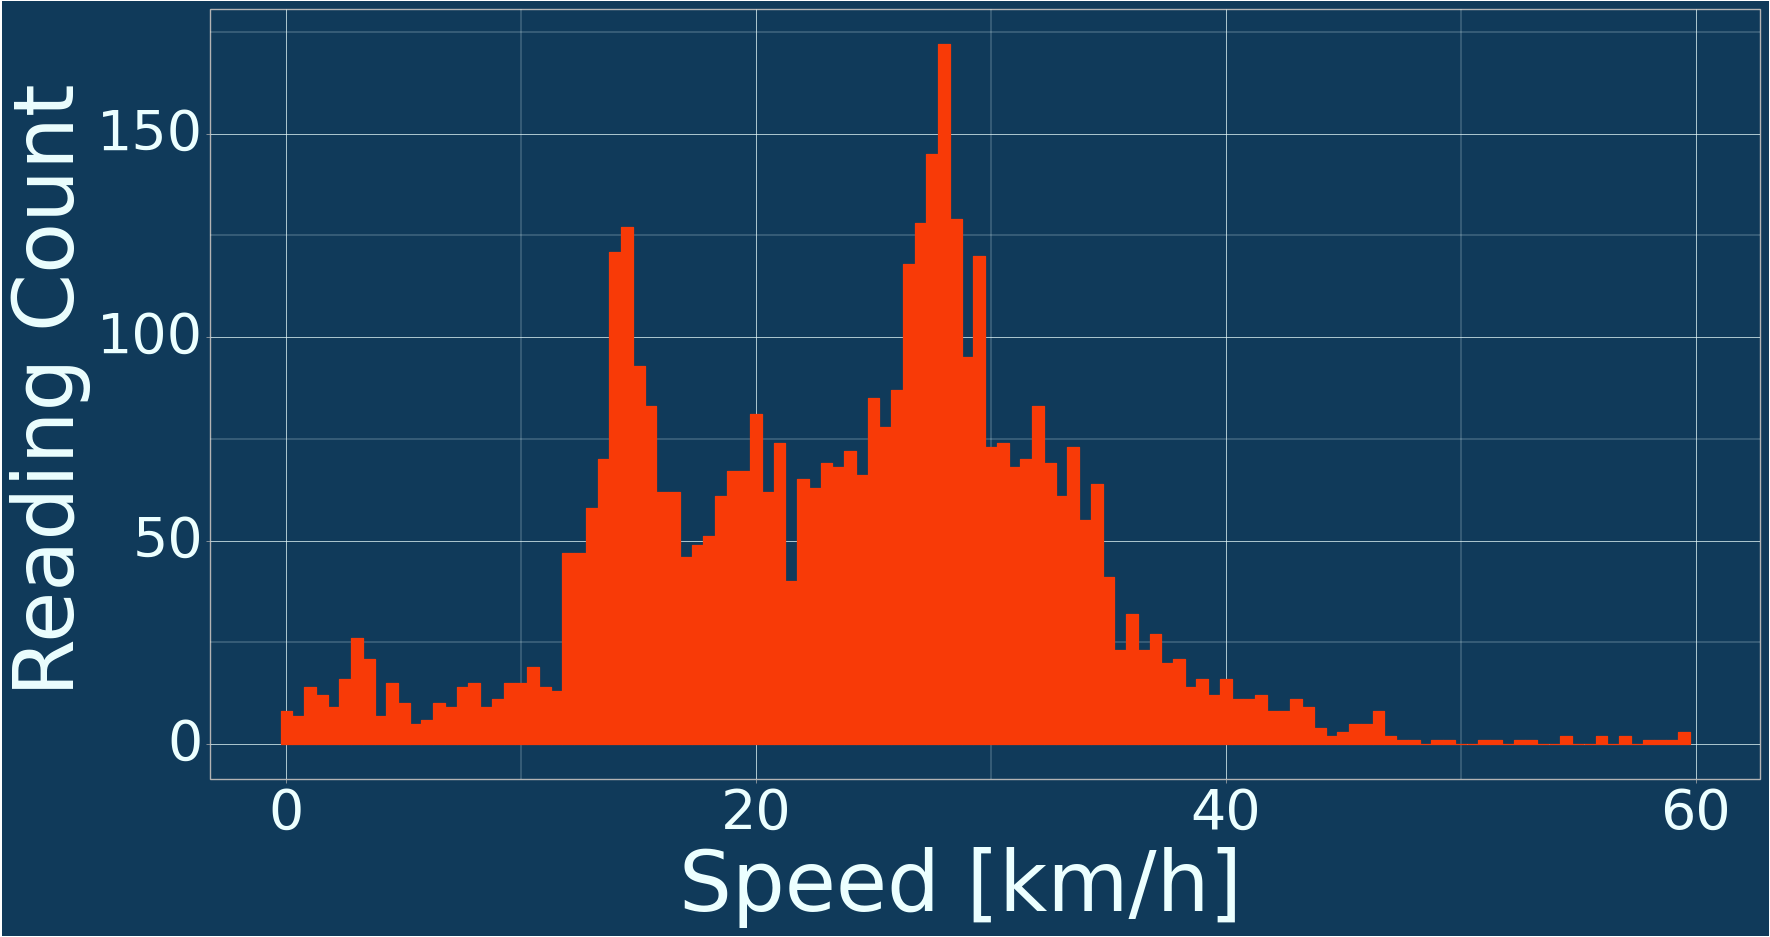

In [76]:
p = (ggplot(stream) + gg.geom_histogram(aes(x="velocity"), colour=stred, fill=stred, binwidth=0.5) 
    + pt.gg_theme() 
    + gg.theme(figure_size=(20, 10))
    + gg.xlab("Speed [km/h]")
    + gg.ylab("Reading Count"))

p.save(filename="../plots/plot_components/speed_histogram.png", format="png", height=plot_height, width=plot_width, limitsize=False, transparent=False)
print(p)